# Image Compression and Generation using Variational Autoencoders in Python

### Project Outline


**Task 1**: Exploratory Data Analysis and Preprocessing

**Task 2**: Training/Validation Split

**Task 3**: Creating Data Loaders

**Task 4**: VAE Architecture and Model Creation

**Task 5**: Training Loop

**Task 6**: Results and Other Uses

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm

import os
import shutil
import random
random.seed(5)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

C:\Users\utkarsh\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
epochs = 1000
batch_size = 64
torch.manual_seed(17)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## Task 1: Exploratory Data Analysis and Preprocessing

We use the computer-generated fonts of the [Character Font Images Data Set](http://archive.ics.uci.edu/ml/datasets/Character+Font+Images#).

In [3]:
def show_img(img):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    plt.title(f'Image has size {img.cpu().numpy().shape}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor(),
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder('Font/all/', transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

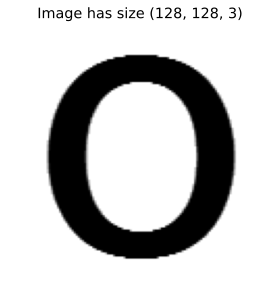

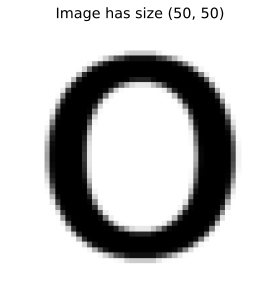

In [5]:
for batch in dummy_batch:
    original_image = batch[0][0]
    show_img(original_image)
    show_img(transforms_all(transforms.ToPILImage()(original_image)))
    break

## Task 2: Training/Validation Split

In [6]:
folders = os.listdir('Font/all')

# ignore hidden files
folders = [folder for folder in folders if folder[0]!='.']

os.mkdir('Font/train')
os.mkdir('Font/val')

for folder in tqdm(folders):
    os.mkdir(f'Font/val/{folder}')
    os.mkdir(f'Font/train/{folder}')
    
    images = os.listdir(f'Font/all/{folder}')
    
    # ignore hidden files
    images = [image for image in images if image[0]!='.']
    
    random.shuffle(images)
    for image in images[:20]:
        shutil.copy(f'Font/all/{folder}/{image}', f'Font/val/{folder}/{image}')
        
    for image in images[20:]:
        shutil.copy(f'Font/all/{folder}/{image}', f'Font/train/{folder}/{image}')

  0%|          | 0/62 [00:00<?, ?it/s]

## Task 3: Creating Data Loaders

In [7]:
transforms_set = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('Font/train', transform=transforms_set),
    batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('Font/val', transform=transforms_set),
    batch_size=batch_size, shuffle=True)

## Task 4: VAE Architecture and Model Creation

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
    
        z = 32
        
        self.fc1 = nn.Linear(50*50, 1000)
        self.fc21 = nn.Linear(1000, z)
        self.fc22 = nn.Linear(1000, z)
        self.fc3 = nn.Linear(z, 1000)
        self.fc4 = nn.Linear(1000, 50*50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [10]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 50*50), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [11]:
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Task 5: Training Loop

In [360]:
def evaluate(evaluate_data=val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            
            data = data.to(device)
            
            recon_batch, mu, logvar = model(data)
            
            val_loss += loss_function(recon_batch, data, mu, logvar).item()
            
            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 50, 50)[:n]])
                save_image(comparison.cpu(),
                         'Results/reconstruction_' + str(epoch) + '.png', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 50, 50),
                   'Results/sample_' + str(epoch) + '.png')

In [341]:
def train(epoch):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:
        
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    if epoch%50==0:
        torch.save(model.state_dict(), f'Models/epoch_{epoch}.model')

In [343]:
epochs=2

In [344]:
train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    train(epoch)
    sample_latent_space(epoch)
    
np.savetxt('Models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('Models/validation_losses.txt', np.array(val_losses), delimiter='\n')

Training set loss (average, epoch 001): 266.831
				====> Validation set loss: 266.324


Training set loss (average, epoch 002): 265.057
				====> Validation set loss: 263.595


In [349]:
model.load_state_dict(torch.load('Presaved_Models/epoch_950.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [361]:
for i in range(100):
    sample_latent_space(f'-{i}')

## Task 6: Results and Other Uses

In [336]:
train_losses = np.loadtxt('Presaved_Models/training_losses.txt')
val_losses = np.loadtxt('Presaved_Models/validation_losses.txt')

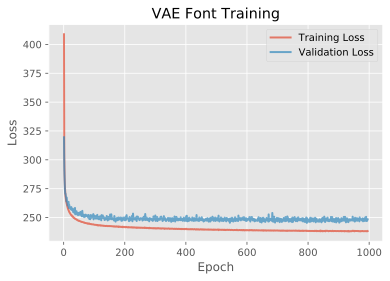

In [337]:
plt.plot(
    range(1, len(train_losses)+1), 
    train_losses, 
    label='Training Loss',
    linewidth=2, 
    alpha=0.7
)

plt.plot(
    range(1, len(val_losses)+1),
    val_losses,
    label='Validation Loss',
    linewidth=2,
    alpha=0.7
)

plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
pass